# Synthetic model using the CRUST1.0 model

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import multiprocessing
import time
from IPython.display import Image
from fatiando.vis import myv, mpl
from fatiando.gravmag import tesseroid
from fatiando import gridder, utils
from fatiando.inversion import Smoothness2D
import fatiando
from tesseroid_mesh import TesseroidRelief
from crust1 import fetch_crust1
from moho import MohoGravityInvSpherical, cross_validation, make_mesh

In [2]:
print(fatiando.__version__)

0.3-367-gd3a8f4a-dirty


In [3]:
ncpu = multiprocessing.cpu_count()
ncpu

4

## Load the model and make some data

In [4]:
crust1 = fetch_crust1('../data/crust1.0.tar.gz').cut((-60, 15, -85, -30))
area = [crust1.lats[0], crust1.lats[-1], crust1.lons[0], crust1.lons[-1]]

In [5]:
reference = -30e3

In [6]:
moho_density_contrast = crust1.density[7] - 3200
moho_density_contrast[-crust1.moho_depth > reference] *= -1

In [7]:
bm = Basemap(projection='cyl', llcrnrlon=area[2], urcrnrlon=area[3], llcrnrlat=area[0], urcrnrlat=area[1],
             lon_0=0.5*(area[2] + area[3]), lat_0=0.5*(area[1] + area[0]), resolution='c')
x, y = bm(crust1.lon, crust1.lat)

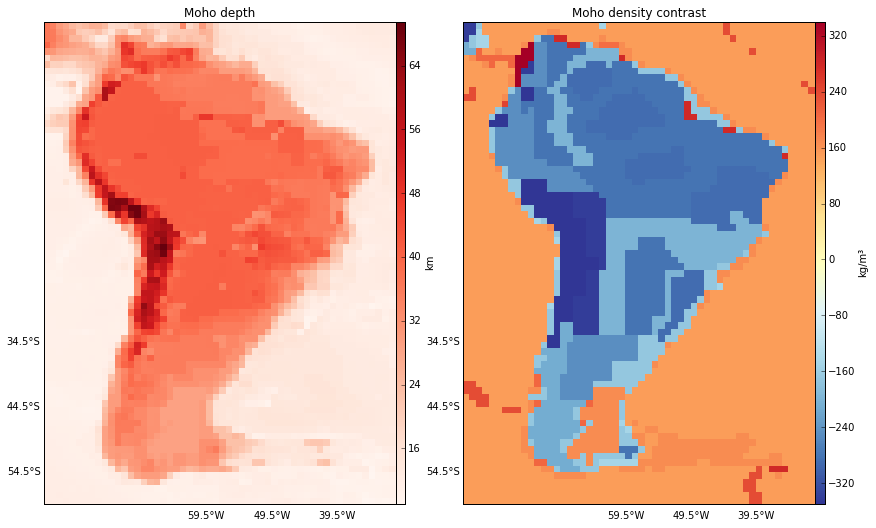

In [8]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.title('Moho depth')
bm.pcolor(x, y, 0.001*crust1.moho_depth, cmap='Reds')
plt.colorbar(pad=0, aspect=50).set_label('km')
bm.drawmeridians(np.arange(area[0], area[1], 10), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(np.arange(area[2], area[3], 10), labels=[1, 0, 0, 0], linewidth=0)
plt.subplot(1, 2, 2)
plt.title('Moho density contrast')
bm.pcolor(x, y, moho_density_contrast, cmap='RdYlBu_r')
plt.colorbar(pad=0, aspect=50).set_label(u'kg/m³')
bm.drawmeridians(np.arange(area[0], area[1], 10), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(np.arange(area[2], area[3], 10), labels=[1, 0, 0, 0], linewidth=0)
plt.tight_layout()

Setup the computation grid.

In [9]:
lon, lat = crust1.lon.ravel(), crust1.lat.ravel()
height = 50e3*np.ones_like(lon)
shape = crust1.density.shape[1:]
shape

(75, 55)

Setup the model.

In [10]:
model = TesseroidRelief(area, shape, relief=-crust1.moho_depth.ravel(), reference=reference, 
                        props={'density': moho_density_contrast.ravel()})

Calculate the synthetic data.

In [11]:
data = tesseroid.gz(lon, lat, height, model, njobs=ncpu)

In [12]:
noisy_data = utils.contaminate(data, 5)

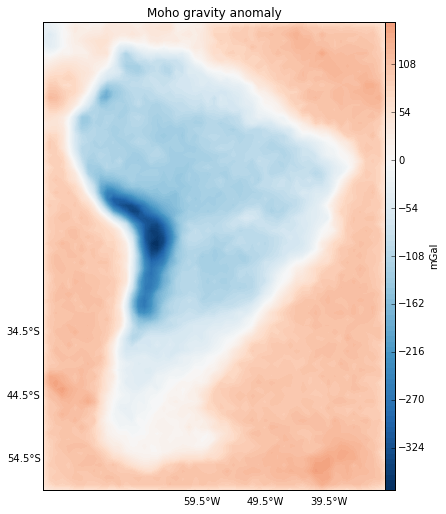

In [13]:
plt.figure(figsize=(6, 7))
plt.title('Moho gravity anomaly')
amp = np.abs([data.min(), data.max()]).max()
bm.contourf(x, y, noisy_data.reshape(shape), 100, cmap='RdBu_r', vmin=-amp, vmax=amp)
plt.colorbar(pad=0, aspect=50).set_label('mGal')
bm.drawmeridians(np.arange(area[0], area[1], 10), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(np.arange(area[2], area[3], 10), labels=[1, 0, 0, 0], linewidth=0)
plt.tight_layout()

## Inversion setup

In [14]:
mesh = model.copy(deep=True)
initial = np.ones(mesh.size)*(reference - 10e3)
config = dict(method='newton', tol=0.2, maxit=7, initial=initial)

In [15]:
misfit = MohoGravityInvSpherical(lon, lat, height, data, mesh, njobs=ncpu)
regul = Smoothness2D(mesh.shape)

Cross-validation data-set.

In [16]:
test_shape = [int(s*1.2) for s in shape]
print(test_shape)
test_lat, test_lon, test_h = gridder.regular(area, test_shape, z=10e3)
test_data = tesseroid.gz(test_lon, test_lat, test_h, model, njobs=ncpu)
test_data = utils.contaminate(test_data, 5, seed=10)  # Use a different seed to get independent errors

[90, 66]


In [17]:
test_set = MohoGravityInvSpherical(test_lat, test_lon, test_h, test_data, mesh)

moho.py:71: RuntimeWarning: The mesh size (4125) is different from the data size (5940). The mesh elements should be below each data point. Make sure you know what you're doing.
  warnings.warn(msg, RuntimeWarning)


## Inversion with known density and reference

In [19]:
regul_params = np.logspace(-10, -5, 5)

In [20]:
%time results = cross_validation(misfit, regul, regul_params, config, test_set, njobs=1)

ZeroDivisionError: division by zero

In [ ]:
ibest, solver, scores, solvers = results

In [ ]:
plt.figure()
plt.plot(regul_params, steep_scores, '.-k')
plt.plot(regul_params[ibest], scores[ibest], '^b', markersize=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Regularization parameter')
plt.ylabel('RMS')
plt.title('Cross-validation for {}'.format(solver.stats_['method']))

In [ ]:
plt.figure()
ax1 = plt.subplot(111)
rms = np.sqrt(steep.stats_['objective'])/np.sqrt(misfit.ndata)
ax1.plot(rms, '.k-')
ax1.set_ylabel('RMS (mGal)')
ax1.set_xlabel('Iteration')
ax1.set_title(steep.stats_['method'])

In [ ]:
residuals = solver.residuals()
predicted = solver.predicted()
moho = solver.estimate_
residuals.mean(), residuals.std()

In [ ]:
plt.figure()
_ = plt.hist(residuals, 20, normed=True)

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.title('Moho depth')
bm.pcolor(x, y, 0.001*crust1.moho_depth, cmap='Reds')
plt.colorbar(pad=0, aspect=50).set_label('km')
bm.drawmeridians(range(area[0], area[1], 10), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(range(area[2], area[3], 10), labels=[1, 0, 0, 0], linewidth=0)
plt.subplot(1, 2, 2)
plt.title('Estimated depth')
bm.pcolor(x, y, -0.001*moho.relief.reshape(shape), cmap='Reds')
plt.colorbar(pad=0, aspect=50).set_label(u'km')
bm.drawmeridians(range(area[0], area[1], 10), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(range(area[2], area[3], 10), labels=[1, 0, 0, 0], linewidth=0)
plt.tight_layout()

In [ ]:
plt.figure(figsize=(6, 7))
plt.title('Difference')
bm.pcolor(x, y, -0.001*(model.relief - moho.relief.reshape(shape)), cmap='Reds')
plt.colorbar(pad=0, aspect=50).set_label('km')
bm.drawmeridians(range(area[0], area[1], 10), labels=[0, 0, 0, 1], linewidth=0)
bm.drawparallels(range(area[2], area[3], 10), labels=[1, 0, 0, 0], linewidth=0)
plt.tight_layout()